In [1]:
import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import measure
from skimage.filters import gaussian, threshold_otsu
from skimage.segmentation import clear_border
from scipy import ndimage as ndi
import cv2

In [2]:
def rmbackground(image):
    white = np.array([255, 255, 255])
    mask = np.abs(image - white).sum(axis=2) < 0.05

    # Find the bounding box of those pixels
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    out = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    return out

In [11]:
# create input_images folder and sub-folders as required by the model (create only once)
'''
import os
os.mkdir("data/input_images")
os.mkdir("data/input_images/class1")
os.mkdir("data/input_images/class2")
os.mkdir("data/input_images/class3")
'''

In [12]:
x_file_name = 'data/Numeric_data_for_cells_COMBINED.xls'
frame_no = "109" # images are named as filename_frame_no.tif, eg. 1_2_5_1_14_109.tif
img_dir = "data/cell_images"
result_dir = "data/input_images"

x_data_xls = pd.ExcelFile(x_file_name)
df = pd.read_excel(x_data_xls, x_data_xls.sheet_names[-1], header=None) # read the last sheet for this case
collections = list()
for ind in tqdm(range(df.shape[0])):
    filename = df.iloc[ind, -3] # filename is the 3rd last column
    class_name = "class"+str(df.iloc[ind, -1]) # class is the last column
    original = cv2.imread(img_dir+"/"+filename+"_"+frame_no+".tif")
    # remove a white background
    nobg = rmbackground(original)
    # resize to 60x60 pixels and check for duplicates
    resize_img = cv2.resize(nobg, (60,60), interpolation= cv2.INTER_LINEAR)
    duplicate = False
    for im in collections:
        if (resize_img == im).all():
            duplicate = True
            break
    if duplicate:
        continue
    collections.append(resize_img)
    # segment the nucleus
    gray = cv2.cvtColor(nobg, cv2.COLOR_BGR2GRAY)
    smooth = gaussian(gray, sigma=1.5)
    thresh = smooth > threshold_otsu(smooth)
    fill = ndi.binary_fill_holes(thresh)
    nucleus_seg = clear_border(fill)
    labels = measure.label(nucleus_seg)
    props = measure.regionprops(labels)
    if len(props) == 1:
        # save the nucleus image
        processed_img = nucleus_seg*gray
        cv2.imwrite(result_dir+"/"+class_name+'/'+filename+"_"+frame_no+'.png', processed_img)

100%|██████████| 2694/2694 [00:14<00:00, 184.17it/s]


Before processing:


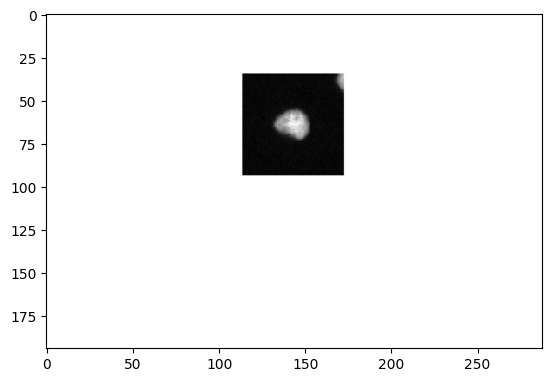

In [13]:
print("Before processing:")
plt.imshow(original, cmap="gray")
plt.show()

After processing:


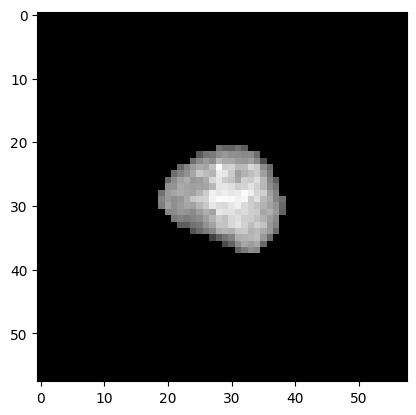

In [14]:
print("After processing:")
plt.imshow(processed_img, cmap="gray")
plt.show()